In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from utils.code_exercise1 import my_window, get_fundamental_freq
from utils.code_exercise2 import compute_stft, compute_istft, plot_spectrum
from scipy.signal import get_window
import sounddevice

/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/christoper/.pyenv/versions/3.7.6/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
y, sr = librosa.core.load("data/exercise7/noisySensor.wav", sr=None, mono=False)

In [3]:
frame_length = 128
frame_shift = 32
n_length = int(sr * frame_length / 1000) 
n_shift = int(sr * frame_shift / 1000)
total_segments = 1 + (y.shape[1] - n_length) // n_shift
hann_win = get_window('hann', n_length)
sqrt_hann_win = np.sqrt(hann_win)

In [4]:
res = np.apply_along_axis(compute_stft, 1,y, sr, frame_length, frame_shift, sqrt_hann_win)


In [5]:
Y = res[:,0] * 0.5
Y = np.stack(Y)
v_freq = res[0,1]
v_time = res[0,2]

In [6]:
d = 0.05
theta = np.pi / 4
c = 340
M = 4
N = v_freq.shape[0] + 1

In [7]:
def get_a():
    time_delays = np.array([ i*d*np.cos(theta) / c for i in range(M)])
    a = np.array([ np.exp(-1j * 2 * np.pi * i /N * sr * time_delays[i]) for i in range(M)])
    return a

In [8]:
def delay_sum(Y):
    S = []
    for i, a in enumerate(get_a()):
        S.append(a.conj().T * Y[i] / M)
        
    S = np.array(S).sum(0)
    return np.array(S)

In [9]:
def to_db(m_stft):
    return 10 * np.log10(np.maximum(np.square(np.abs(m_stft)), 10**( -15)))

## Noisy signal first mic

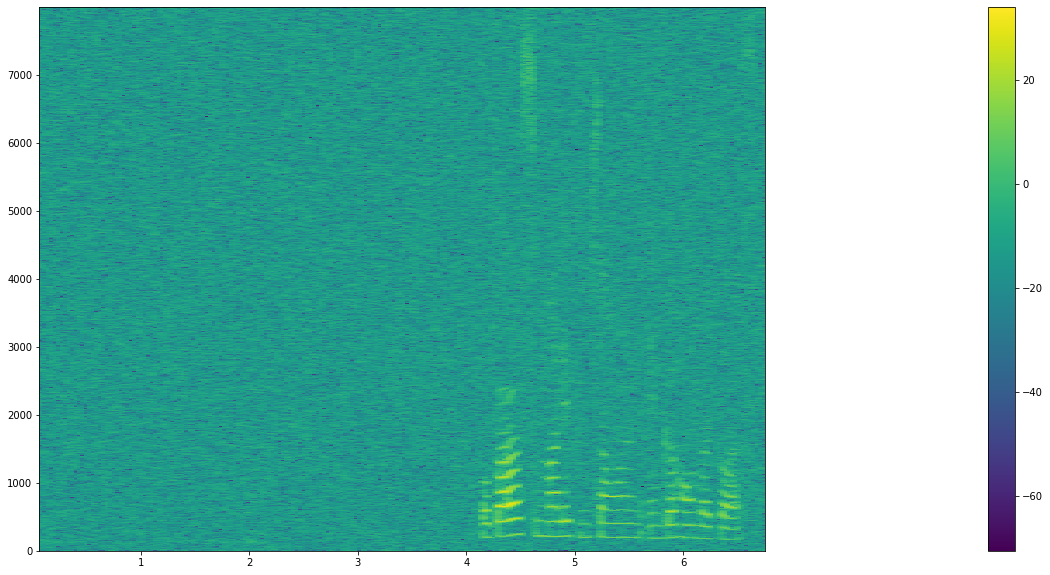

In [10]:
plot_spectrum(Y[0], v_freq, v_time)

In [11]:
S_delay_sum = delay_sum(Y)

In [12]:
y_clean = compute_istft(S_delay_sum, sr, frame_shift, sqrt_hann_win)

In [13]:
sounddevice.play(y_clean, samplerate=sr)

In [14]:
sounddevice.play(y[0], samplerate=sr)

## MVDR

In [15]:
def mvdr(Y, L=5):
    noise = Y[0,:L].sum(0) / L
    phi = np.cov(noise, noise.conj().T)
    a = get_a().reshape(-1,1)

    inv_phi_a = np.linalg.solve(phi, a.reshape(2,2)).reshape(M)
    h = inv_phi_a / (a.conj().T @ inv_phi_a)
    S_mvdr = []
    for i, h_val in enumerate(h):
        S_mvdr.append(h_val.conj().T * Y[i] )
    S_mvdr = np.array(S_mvdr).sum(0)
    return S_mvdr

In [16]:
S_mvdr = mvdr(Y)

In [17]:
y_mvdr = compute_istft(S_mvdr, sr, frame_shift, sqrt_hann_win)

In [18]:
sounddevice.play(y_mvdr, samplerate=sr)

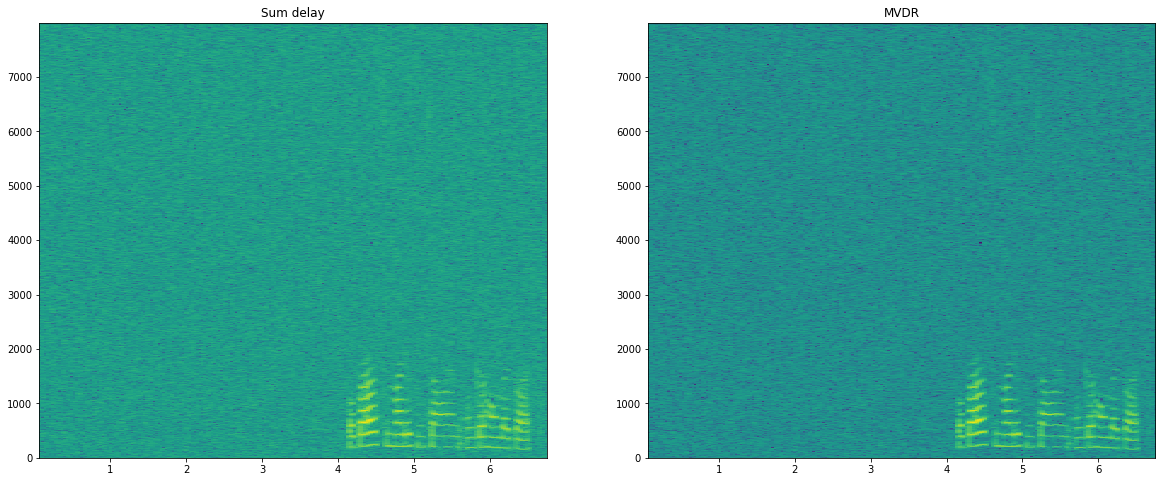

In [19]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
ax.set_title("Sum delay")

im = ax.imshow(to_db(S_delay_sum).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')

ax = fig.add_subplot(122)
ax.set_title("MVDR")
im = ax.imshow(to_db(S_mvdr).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')


## noisyIsotropic

In [20]:
y_is, sr_is = librosa.core.load("data/exercise7/noisyIsotropic.wav", sr=None, mono=False)

In [21]:
res_is = np.apply_along_axis(compute_stft, 1,y_is, sr_is, frame_length, frame_shift, sqrt_hann_win)

In [22]:
Y_is = res[:,0] * 0.5
Y_is = np.stack(Y_is)

In [23]:
S_is_delay = delay_sum(Y_is)
y_is_delay = compute_istft(S_is_delay, sr, frame_shift, sqrt_hann_win)

In [24]:
S_is_mvdr = mvdr(Y_is)
y_is_mvdr = compute_istft(S_is_delay, sr, frame_shift, sqrt_hann_win)

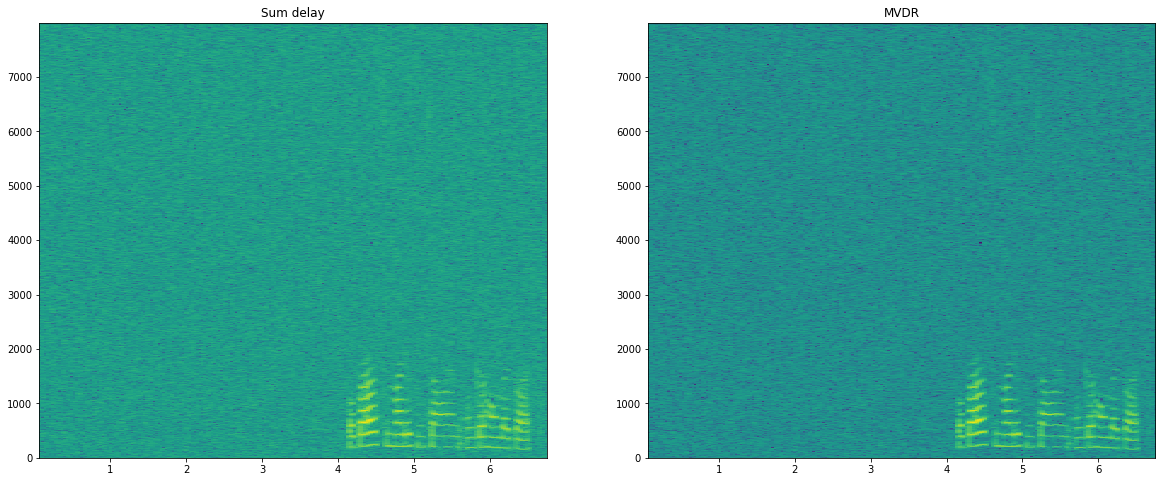

In [25]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
ax.set_title("Sum delay")

im = ax.imshow(to_db(S_is_delay).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')

ax = fig.add_subplot(122)
ax.set_title("MVDR")
im = ax.imshow(to_db(S_is_mvdr).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')


## Soundplay

In [26]:
sounddevice.play(y_is[0], samplerate=sr)

In [27]:
sounddevice.play(y_is_delay, samplerate=sr)

In [28]:
sounddevice.play(y_is_mvdr, samplerate=sr)

## noisyDirectional

In [29]:
y_dir, sr_dir = librosa.core.load("data/exercise7/noisyDirectional.wav", sr=None, mono=False)
res_dir = np.apply_along_axis(compute_stft, 1,y_dir, sr_dir, frame_length, frame_shift, sqrt_hann_win)
Y_dir = res[:,0] * 0.5
Y_dir = np.stack(Y_dir)

In [30]:
theta = 150 / 180 * np.pi

### sum delay

In [31]:
S_dir_delay = delay_sum(Y_dir)
y_dir_delay = compute_istft(S_dir_delay, sr, frame_shift, sqrt_hann_win)

In [32]:
S_dir_mvdr = mvdr(Y_dir)
y_dir_mvdr = compute_istft(S_dir_delay, sr, frame_shift, sqrt_hann_win)

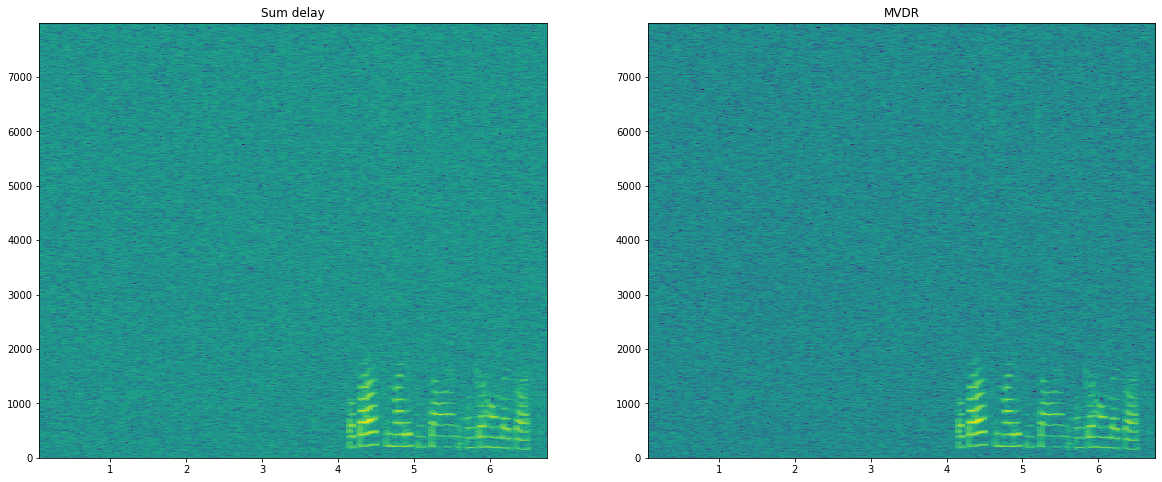

In [33]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
ax.set_title("Sum delay")

im = ax.imshow(to_db(S_dir_delay).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')

ax = fig.add_subplot(122)
ax.set_title("MVDR")
im = ax.imshow(to_db(S_dir_mvdr).T,
                cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                v_freq [ -1]] , aspect ='auto')


In [34]:
sounddevice.play(y_dir[0], samplerate=sr)

In [35]:
sounddevice.play(y_dir_delay, samplerate=sr)

In [36]:
sounddevice.play(y_dir_mvdr, samplerate=sr)